In [1]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

project_folder = "/content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/"

Mounted at /content/drive


In [2]:
######################
## Imports
######################


import os
import numpy as np
from copy import copy
from sklearn.model_selection import train_test_split
from google.colab import drive
import random

%tensorflow_version 1.x
import tensorflow as tf
#print(tf.__version__)
#tf.reset_default_graph()
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc as smp
from tensorflow.python import debug as tf_debug
import datetime
import pandas as pd
import collections

from PIL import Image, ImageOps



TensorFlow 1.x selected.


In [3]:
matplotlib.rcParams.update({'font.size': 22})

In [33]:
##################################
## Load data: trX, trY, teX, teY, img_size
##################################




# Load big data set: 60.000 images used to do the analysis in the paper
# df_big = pd.read_csv(project_folder + 'data/train_test/data_train_test.csv')
# X_ = np.load(project_folder + 'data/train_test/imgs_train_test.npy')
# y_ = df_big.num.values
# exp_name = '_squares_rand'


# Load equal-square-size data set:
# df_big = pd.read_csv(project_folder + 'data/equal_square_size/data_equal_square_size_60000.csv')
# X_ = np.load(project_folder + 'data/equal_square_size/data_equal_square_size_60000.npy')
# y_ = df_big.num.values
# exp_name = '_squares_equal'

# Load rectangle data set:
df_big = pd.read_csv(project_folder + 'data/rectangle/data_rectangle_60000.csv')
X_ = np.load(project_folder + 'data/rectangle/data_rectangle_60000.npy')
y_ = df_big.num.values
exp_name = '_rectangles_rand'

# Load rectangle (fixed total area) data set:
# df_big = pd.read_csv(project_folder + 'data/rectangle/data_rectangle_fixed_total_area_60000.csv')
# X_ = np.load(project_folder + 'data/rectangle/data_rectangle_fixed_total_area_60000.npy')
# y_ = df_big.num.values
# exp_name = '_rectangles_fixed_total'

#those npy files should be in the folder data on gitlab/numerosity estimation project folder
# Split data in train/test sets
trX, teX, trY_labels, teY_labels = train_test_split(X_, y_, test_size=0.25, random_state=9, stratify=y_)

def one_hot(a, num_classes):
  b = copy(a)
  for i in range(a[:].size):
    b[i] = b[i] - 1 
  return np.squeeze(np.eye(num_classes)[b.reshape(-1)])

trY = one_hot(trY_labels,10)
teY = one_hot(teY_labels,10)

print (trX.shape, trY.shape, teX.shape, teY.shape)
print (trX.max(), trX.min(), teX.max(), teX.min())
print (trY_labels.max(), trY_labels.min(), teY_labels.max(), teY_labels.min())

img_size = int(np.sqrt(trX[0,:].size))
max_objects = 10

####################









(45000, 784) (45000, 10) (15000, 784) (15000, 10)
255 0 255 0
10 1 10 1


In [32]:
############################
## Define TensorFlow Model
############################


#from tensorflow.contrib.tensorboard.plugins import projector

n_hidden_neurons = 90


tf.reset_default_graph()

################################
## AUXILIARY FUNCTIONS
################################
def array_to_image(data):
    img = smp.toimage(np.reshape(data, (img_size,img_size)))
    return  img

def init_weights(shape, name):
    return tf.Variable(tf.random_normal(shape, stddev=0.01), name=name)
  
def conv_to_tensorboard(conv_layer, conv_name, scope_name ):
    with tf.variable_scope(scope_name):
        kernel_str = conv_name + '/kernel:0' #'/kernel/RMSProp:0' # #  #RMSProp_1:0
        kernel = tf.get_collection(tf.GraphKeys.VARIABLES, kernel_str)[0]
         # scale weights to [0 1], type is still float
        x_min = tf.reduce_min(kernel)
        x_max = tf.reduce_max(kernel)
        kernel_0_to_1 = (kernel - x_min) / (x_max - x_min)
        # to tf.image_summary format [batch_size, height, width, channels]
        kernel_transposed = tf.transpose (kernel_0_to_1, [3, 0, 1, 2])
        #kernel_transposed = tf.reshape(tf.transpose (kernel_0_to_1, [3, 0, 1, 2]), [-1,3,3,1])
        #kernel_transposed = kernel_0_to_1
        # this will display random 3 filters from the 64 in conv1
        #img = Image.fromarray(kernel_transposed.numpy()*255).resize( (100,100), resample=0).convert('RGB') 
        #('conv1_filters', img ,max_outputs=32)
        kernel_transposed = tf.image.resize(kernel_transposed, [10,10], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        #image = tf.summary.image('conv1_filters', kernel_transposed,max_outputs=32)
        
        tf.summary.image('conv2_filters', kernel_transposed,max_outputs=64)
        
def layer_and_input_activ_to_tensorboard(layer, inputt, input_id, scope_name, img_w, img_h):
    with tf.name_scope("Sizes"):
      layer_shape = layer.get_shape().as_list()
      widthy = layer.get_shape().as_list()[1]
      whole_layer = layer
    imgy = tf.reshape(layer, [-1, img_w, img_h, 1])    
    imgy2 = tf.reshape(inputt, [-1, img_size, img_size, 1])
    input_str = 'Input_' + input_id
    layer_str = scope_name + '_of_' + input_str
    tf.summary.image(input_id, imgy)
    tf.summary.image(input_id, imgy2)

    
################################
## NN - Models
################################




def conv_net(x_arr, n_classes, dropout, is_training, reuse):
    # data input might come as a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x_arr, shape=[-1, img_size, img_size, 1])

    # Convolution Layer with 32 filters and a kernel size of 5
    with tf.name_scope("conv1"):
      #kernel = _variable_with_weight_decay('weights', shape=[5, 5, 3, 64],
       #                                stddev=1e-4, wd=0.0)
      #conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
      #conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
      conv1 = tf.layers.conv2d(inputs=x,filters=8,kernel_size=[5, 5],padding="same",activation=tf.nn.relu, name='conv1',trainable=True)
      #conv1 = tf.layers.conv2d(inputs=x,filters=8,kernel_size=[5, 5],padding="same",activation=tf.nn.relu, name='conv1')    #original
      # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
      conv1_pool = tf.layers.max_pooling2d(conv1, 2, 2)

    # Convolution Layer with 64 filters and a kernel size of 3
    with tf.name_scope("conv2"):
      conv2 = tf.layers.conv2d(conv1_pool, 64, 3, activation=tf.nn.relu, name='conv2',trainable=True)
      #conv2 = tf.layers.conv2d(conv1, 8, 3, activation=tf.nn.relu, name='conv2')  #original
      # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
      conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

    # Flatten the data to a 1-D vector for the fully connected layer
    conv2_flatten = tf.contrib.layers.flatten(conv2)
    # Fully connected layer (in tf contrib folder for now)
    fc1 = tf.layers.dense(conv2_flatten, n_hidden_neurons)   #original 1024
    # Apply Dropout (if is_training is False, dropout is not applied)
    fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)
    fc1 = tf.sigmoid(fc1)
    

    #new_test_layer = tf.math.multiply(tf_test_layer_stacked, tf_filty_stacked)
    fc1 = tf.math.multiply(fc1, filtery)
    
    
    # Output layer, class prediction
    out = tf.nn.softmax(tf.layers.dense(fc1, n_classes))
    
    ######################
    #### PLOT LAYERS IN TENSORBOARD
    ######################
    conv_to_tensorboard(conv1, 'conv1', 'Conv1_Kernel_visualization' ) 
    #conv_to_tensorboard(conv2, 'conv2', 'Conv2_Kernel_visualization' ) 
    
    layer_shape = fc1[0].get_shape()
    widthy = fc1.get_shape().as_list()[1]
    whole_layer = fc1
    
    '''
    with tf.variable_scope('Last_layer_activation'):
      for obj in range(5):   
        layer_and_input_activ_to_tensorboard(fc1[obj:obj+1], x[obj:obj+1], str(obj), 'Last_layer_activation',3,3)
    '''
       
    with tf.variable_scope('conv1'):
      for obj in range(5):   
        layer_and_input_activ_to_tensorboard(conv1[obj:obj+1], x[obj:obj+1], str(obj), 'conv1_activation',img_size,img_size)  
    
      

       
    return out, fc1




##########################################
## CREATE QUANTITIES/PLACEHOLDERS and SET THEM INTO NN
#########################################

#Step 2 - Create input and output placeholders for data
X = tf.placeholder("float", [None, trX[0,:].size], name="X")
Y = tf.placeholder("float", [None, trY[0,:].size], name="Y")

filtery = tf.placeholder("float", [None, n_hidden_neurons], name="Y")

is_training = tf.placeholder(tf.bool)
failed_object = tf.placeholder(tf.int32, name="FAILY")
failed_object_string = tf.placeholder(dtype=tf.string)

#Step 3 - Initialize weights


#Step 5 - Add dropout to input and hidden layers
p_keep_input = tf.placeholder("float", name="p_keep_input")
p_keep_hidden = tf.placeholder("float", name="p_keep_hidden")



#Step 6 - Create Model
#py_x = fully_connected_net(X, w_h, w_h2, w_o, p_keep_input, p_keep_hidden)
py_x, fc1 = conv_net(X, trY[0,:].size, 0.25, is_training, reuse=False)




##########################################
## COST + TRAIN_STEP
#########################################
#Step 7 Create cost function
with tf.name_scope("cost"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x,labels= Y))
    train_op = tf.train.RMSPropOptimizer(0.0005, 0.7).minimize(cost)
    # Add scalar summary for cost tensor
    tf.summary.scalar("cost", cost)

#Step 8 Measure accuracy
with tf.name_scope("accuracy"):
    correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(py_x, 1)) # Count correct predictions
    acc_op = tf.reduce_mean(tf.cast(correct_pred, "float")) # Cast boolean to float to average
    # Add scalar summary for accuracy tensor
    tf.summary.scalar("accuracy", acc_op)
   
  
  
##########################################
## PLOT INCORRECT PREDICTIONS
#########################################
with tf.variable_scope('Failed_test_examples'):
  incorrect_pred = tf.not_equal(tf.argmax(Y, 1), tf.argmax(py_x, 1))
  indices = tf.where(incorrect_pred)
  x_arr = tf.reshape(X, shape=[-1, img_size, img_size, 1])
  x_arr_reduced = tf.gather_nd(x_arr, indices)
  imgy2 = tf.reshape(x_arr_reduced, [-1, img_size, img_size, 1])  
  to_tensi = tf.summary.image('Test', imgy2 ,max_outputs=20)


def save_and_plot_acc_cost(file_path, x_values, y_values, y_axis, x_axis='Episodes', y_values_2=None):

    matplotlib.get_backend()
    plt.plot(x_values, y_values, label='Test set')
    if(y_values_2 is not None):
       plt.plot(x_values, y_values_2, label='Train set')
       #plt.legend()
       plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='xx-small')
    plt.ylabel(y_axis)
    plt.xlabel(x_axis)
    if(y_axis=='Accuracy'):
      plt.ylim(0,1)
    #titlestring = 'Accuracy development during learning to count up to ' + str(trY[0].size) + ' object with a CNN'
    titlestring = y_axis + ' development during learning to count up to ' + "10" + ' objects'

    img_path = file_path + "_" + y_axis + ".png"

    plt.title(titlestring, fontsize='small')
    plt.savefig(img_path, dpi = 600)
    plt.show()


def save_and_plot_acc_development_for_each_number(file_path, x_values, y_values):

    matplotlib.get_backend()
    for i in range(y_values[0,:].size):
       plt.plot(x_values, y_values[:, i], label=i)
       plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='xx-small')
       #plt.legend()
      
    plt.ylabel('Accuracy')
    plt.xlabel('Episodes')
    plt.ylim(-0.1,1.1)
    #titlestring = 'Accuracy development during learning to count up to ' + str(trY[0].size) + ' object with a CNN'
    titlestring = 'Accuracy development during learning to count up to ' + "10" + ' objects'

    img_path = file_path + "accuracy_development_for_each_number_.png"

    plt.title(titlestring, fontsize='small')
    plt.savefig(img_path, dpi = 600, bbox_inches = 'tight')
    plt.show()

def save_and_plot_acc_final_for_each_number(file_path, x_values, y_values):

    matplotlib.get_backend()

    plt.plot(x_values, y_values, 's')
    plt.ylabel('Final accuracy')
    plt.xlabel('Episodes')
    plt.ylim(-0.1,1.1)
    #titlestring = 'Accuracy development during learning to count up to ' + str(trY[0].size) + ' object with a CNN'
    titlestring = 'Final accuracy count up to ' + "10" + ' objects'

    img_path = file_path + "accuracy_final_for_each_number_.png"

    plt.title(titlestring, fontsize='small')
    plt.savefig(img_path, dpi = 600, bbox_inches = 'tight')
    plt.show()


def test_for_each_number(teX, teY_labels, num_list=None, turn_off_neurons_list_=None, turn_on_neurons_list_=None):

    if(load_new_session):
      with tf.Session() as sess:

        #sess = tf_debug.TensorBoardDebugWrapperSession(sess, "localhost:6064")
        restore_model_id = model_id
        save_model_path = project_folder + 'models/' + str(restore_model_id) + '/'
        print("model path before: ", save_model_path)
        saver = tf.train.Saver()
        saver.restore(sess, tf.train.latest_checkpoint(save_model_path))
        print("now officially restored")
    ####################################
    ## Test for each numerosity separately and 
    ############################################
    test_acc_for_each_number = []
    test_acc_2 = []
    index_list = []

    if(num_list is None):
      num_list = np.unique(teY_labels)

      
    ### Test single number seperately  
    for i in num_list:

        indis = np.where(teY_labels == i)
        index_list.append(list(indis)[0] )
        teX_sub = teX[indis]
        teY_sub_labels = teY_labels[indis]
        teY_sub = one_hot(teY_sub_labels, 10)
        last_layer_activity = np.zeros( shape=(teX_sub.shape[0],n_hidden_neurons ) )
        
        if(turn_off_neurons_list_ is None and turn_on_neurons_list_ is None):
          tf_filty_stacked_2 = np.ones((teX_sub.shape[0],n_hidden_neurons))
        else:
          if(turn_off_neurons_list_ is not None):
            tf_filty_stacked_2 = create_neuron_filter(teX_sub.shape[0],turn_off_neurons_list_)
          if(turn_on_neurons_list_ is not None):
            tf_filty_stacked_2 = create_neuron_filter_turn_on(teX_sub.shape[0],turn_on_neurons_list_)
                
        indi, acc, last_layer_activity = sess.run([indices, acc_op, fc1], feed_dict={X: teX_sub.astype(np.float32), Y: teY_sub.astype(np.float32),filtery: tf_filty_stacked_2, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
        #last_layer_activity_list.append(last_layer_activity)
        test_acc_for_each_number.append(acc)

    return test_acc_for_each_number

def test_for_each_number_with_new_session(teX, teY_labels, num_list=None, turn_off_neurons_list_=None, turn_on_neurons_list_=None, model_path=None):

      with tf.Session() as sess:
        print("model path before: ", model_path)
        saver = tf.train.Saver()
        saver.restore(sess, tf.train.latest_checkpoint(model_path))
        print("now officially restored")



        ####################################
        ## Test for each numerosity separately and 
        ############################################
        test_acc_for_each_number = []
        test_acc_2 = []
        index_list = []

        if(num_list is None):
          num_list = np.unique(teY_labels)

          
        ### Test single number seperately  
        for i in num_list:

            indis = np.where(teY_labels == i)
            index_list.append(list(indis)[0] )
            teX_sub = teX[indis]
            teY_sub_labels = teY_labels[indis]
            teY_sub = one_hot(teY_sub_labels, 10)
            last_layer_activity = np.zeros( shape=(teX_sub.shape[0],n_hidden_neurons ) )
            
            if(turn_off_neurons_list_ is None and turn_on_neurons_list_ is None):
              tf_filty_stacked_2 = np.ones((teX_sub.shape[0],n_hidden_neurons))
            else:
              if(turn_off_neurons_list_ is not None):
                tf_filty_stacked_2 = create_neuron_filter(teX_sub.shape[0],turn_off_neurons_list_)
              if(turn_on_neurons_list_ is not None):
                tf_filty_stacked_2 = create_neuron_filter_turn_on(teX_sub.shape[0],turn_on_neurons_list_)
                    
            indi, acc, last_layer_activity = sess.run([indices, acc_op, fc1], feed_dict={X: teX_sub.astype(np.float32), Y: teY_sub.astype(np.float32),filtery: tf_filty_stacked_2, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
            #last_layer_activity_list.append(last_layer_activity)
            test_acc_for_each_number.append(acc)

        return test_acc_for_each_number

0 0.466
1 0.5232667
2 0.6212
3 0.5982
4 0.62733334
5 0.58353335
6 0.6816667
7 0.6188667
8 0.6856667
9 0.72146666
10 0.645
11 0.7094667
12 0.80626667
13 0.7629333
14 0.8088
15 0.82533336
16 0.85426664
17 0.83173335
18 0.8553333
19 0.8502
20 0.825
21 0.81333333
22 0.8616667
23 0.859
24 0.7866667
25 0.83213335
26 0.86766666
27 0.95086664
28 0.91973335
29 0.9452
30 0.95453334
31 0.965
32 0.8278667
33 0.94226664
34 0.8198
35 0.76853335
36 0.96313334
37 0.97533333
38 0.9788
39 0.8394667
40 0.877
41 0.9684
42 0.9748667
43 0.9804
44 0.9804
45 0.9632667
46 0.818
47 0.9806
48 0.9690667
49 0.98513335
50 0.98686665
51 0.9856
52 0.9812667
53 0.98413336
54 0.9844667
55 0.97933334
56 0.78346664
57 0.9809333
58 0.9824
59 0.97873336
60 0.89713335
61 0.91893333
62 0.98186666
63 0.96786666
64 0.98786664
65 0.9203333
66 0.9863333
67 0.9877333
68 0.9334
69 0.95886666
70 0.9786
71 0.98753333
72 0.9812667
73 0.9852667
74 0.992
75 0.9896
76 0.98726666
77 0.9356
78 0.99013335
79 0.9832
80 0.98726666
81 0.94226

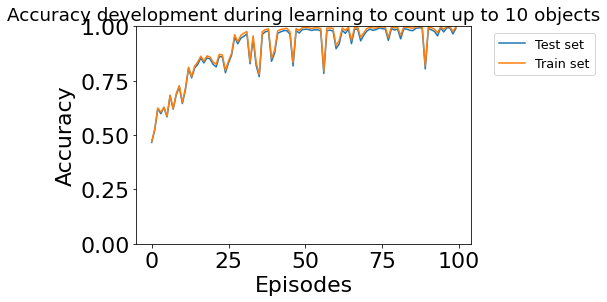

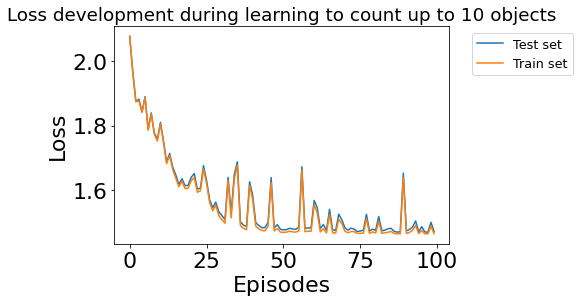

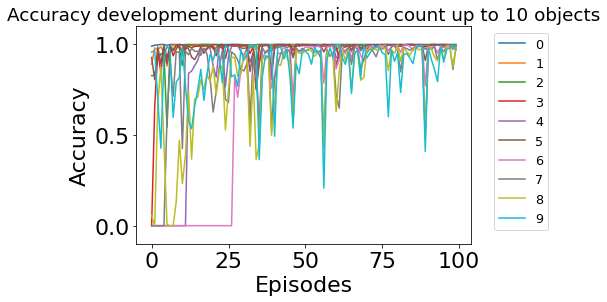

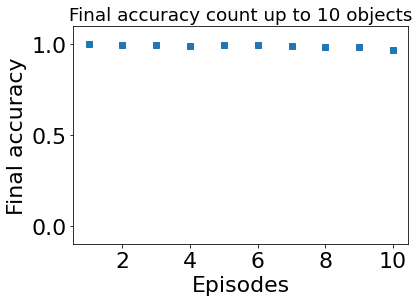

model_id=  2682
0.99153334


In [31]:
    
###############
##########################################
## TRAIN MODEL
## SESSION / ACTUAL RUN - keyyyy
#########################################
###############


#Step 9 Create a session
test_acc_arr = []
test_cost_arr = []
train_acc_arr = []
train_cost_arr = []

test_acc_arr_for_each_number = []


episodes = []
n_episodes = 100

final_acc = np.zeros(10)

## Create 1000 test examples for each number

mult_images = []
mult_classes = []
test_acc = []

with tf.Session() as sess:
        #sess = tf_debug.TensorBoardDebugWrapperSession(sess, "localhost:6064")
        
        now = datetime.datetime.now()
        # Define directory name to log on.
        fily = '/' + str(now.year) + '_' + str(now.month) + '_' + str(now.day) + '_' + str(now.hour) + 'h_' + str(now.minute)
        #fily = "/simple"
        fily = './log' + fily
        #test_writer = tf.train.SummaryWriter(this_test)
        writer = tf.summary.FileWriter(fily, sess.graph) # for 0.8
        merged = tf.summary.merge_all()

        # Step 11 you need to initialize all variables
        tf.initialize_all_variables().run()
        #file_name = os.path.join(dirname, 'logs/events.out.tfevents.1539591730.NTNU15406')
        #save_model_path = '/content/drive/My Drive/Tensorflow_NumEst/saved_models/simple_model'
        result_path = project_folder + 'results/trained_models/'
        model_id = str(random.randint(1000,10000))
        directory_name = str(model_id) + exp_name + "/"
        if(exp_name is None):
          exp_name = ""
        file_name = exp_name + "_nn_model_" + str(model_id) 
        directory_path = result_path + directory_name
        file_path = directory_path + file_name
        save_model_path = file_path

        if(not os.path.exists(directory_path) ):
              os.mkdir(directory_path)

        saver = tf.train.Saver()
        #saver.restore(sess, tf.train.latest_checkpoint(file_name))      ## if you want to get e.g. weights from a last session you can do it here!!!!!!!!
        

        
        
        #Step 12 train the  model
        for i in range(n_episodes):
            #if(i==0):
                #saver.restore(sess, './logs/Last_model')
            n_batch = 80
            batch_bool = 0
            tf_filty_stacked_2 = np.ones((128,n_hidden_neurons))
            if(batch_bool==0):
                for start, end in zip(range(0, len(trX), 128), range(128, len(trX)+1, 128)):
                    sess.run(train_op,                    feed_dict={X: trX[start:end].astype(np.float32), Y: trY[start:end].astype(np.float32),p_keep_input: 0.8, p_keep_hidden: 0.5, is_training: True, filtery:tf_filty_stacked_2})
            else:
                for b in range(int(trX[0,:].size/n_batch)):
                    batch_xs = trX[b*n_batch:b*n_batch+n_batch]
                    batch_ys = trY[b*n_batch:b*n_batch+n_batch]
                    sess.run(train_op, feed_dict={X: batch_xs, Y: batch_ys, p_keep_input: 0.8, p_keep_hidden: 0.5,is_training: True})
                    
            tf_filty_stacked_2 = np.ones((int(teX[:,0].size),n_hidden_neurons))
            indi, summary, test_acc, test_cost = sess.run([indices, merged, acc_op, cost], feed_dict={X: teX.astype(np.float32), Y: teY.astype(np.float32),p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0", filtery:tf_filty_stacked_2})
            tf_filty_stacked_2 = np.ones((int(trX[:,0].size),n_hidden_neurons))
            train_acc, train_cost = sess.run([acc_op, cost], feed_dict={X: trX.astype(np.float32), Y: trY.astype(np.float32),p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0", filtery:tf_filty_stacked_2})

            
          
            writer.add_summary(summary, i)  # Write summary
            print(i, test_acc)                   # Report the accuracy

            ## Append accuracies, costs and episodes
            test_acc_arr = np.append(test_acc_arr,test_acc)
            test_cost_arr = np.append(test_cost_arr,test_cost)
            train_acc_arr = np.append(train_acc_arr,train_acc)
            train_cost_arr = np.append(train_cost_arr,train_cost)
            episodes = np.append(episodes, i)



            test_acc_for_each_number = test_for_each_number(teX, teY_labels, num_list=None)
            
            if(i==0):
              test_acc_arr_for_each_number = np.array([test_acc_for_each_number])
            else:
              test_acc_arr_for_each_number = np.vstack([test_acc_arr_for_each_number,test_acc_for_each_number])



        test_acc_for_each_number = test_for_each_number(teX, teY_labels, num_list=None)

        #### Check for accuracy for final model and each number 
        last_layer_activity = np.zeros( shape=(max_objects,100,n_hidden_neurons ) )
        saver.save(sess, save_model_path)    
        tf_filty_stacked_2 = np.ones((100,n_hidden_neurons))    
        ### Create 1000 test examples for each number of squares each
        #for i in range(max_objects):
        #    mult_img2, mult_class2,areas, orig_areas = Create_N_Images(100, only_one_number=True, n_squares=i+1) 
        #    mult_images.append(mult_img2)
        #    mult_classes.append(mult_class2)
            
        #    indi, summary, acc, last_layer_activity[i,:] = sess.run([indices, merged, acc_op, fc1], feed_dict={X: mult_img2.astype(np.float32), Y: mult_class2.astype(np.float32),filtery: tf_filty_stacked_2, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
        #    final_acc[i] = acc
        #test_acc.append(acc)

        ###### save and plot accuracies, costs, episodes and last layer activity
        # Accuracies and costs during training: for training and test set
        test_acc_path = file_path + "_test_accuracies"
        test_cost_path = file_path + "_test_cost"
        train_acc_path = file_path + "_train_accuracies"
        train_cost_path = file_path + "_train_cost"
        last_layer_act_path = file_path + "_last_layer_activity"
        final_acc_path = file_path + "_final_accuracy"

        np.save(test_acc_path, test_acc_arr)
        np.save(test_cost_path, test_cost_arr)
        np.save(train_acc_path, train_acc_arr)
        np.save(train_cost_path, train_cost_arr)
        np.save(last_layer_act_path, last_layer_activity)
        np.save(final_acc_path, final_acc)

        save_and_plot_acc_cost(file_path, episodes, test_acc_arr, 'Accuracy', x_axis='Episodes', y_values_2=train_acc_arr)
        save_and_plot_acc_cost(file_path, episodes, test_cost_arr, 'Loss', x_axis='Episodes', y_values_2=train_cost_arr)

        save_and_plot_acc_development_for_each_number(file_path, range(n_episodes), test_acc_arr_for_each_number)
        save_and_plot_acc_final_for_each_number(file_path, range(1,max_objects+1), test_acc_for_each_number)


        print("model_id= ", model_id)

     
    
print(test_acc)    



model path before:  /content/drive/MyDrive/Number_Estimation/numerosity-estimation-master-data/results/trained_models/1707_squares_rand/
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/results/trained_models/1707_squares_rand/_squares_rand_nn_model_1707
now officially restored
test_acc_for_each_number:  [0.9620596, 0.8961822, 0.8579767, 0.75880396, 0.72459894, 0.59766966, 0.6064389, 0.51040965, 0.37575352, 0.99409837]


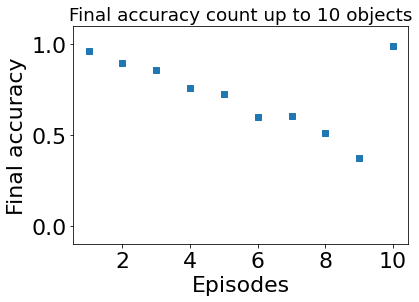

In [35]:
###############
## Test for generalization: squares-rand (trained) --> rectangle-rand (tested)
##########################
model_path = '/content/drive/MyDrive/Number_Estimation/numerosity-estimation-master-data/results/trained_models/1707_squares_rand/'
test_acc_for_each_number = test_for_each_number_with_new_session(teX, teY_labels, model_path=model_path)
print('test_acc_for_each_number: ', test_acc_for_each_number)

matplotlib.get_backend()

x_values = range(1,max_objects+1)
y_values = test_acc_for_each_number
plt.plot(x_values, y_values, 's')
plt.ylabel('Final accuracy')
plt.xlabel('Episodes')
plt.ylim(-0.1,1.1)
#titlestring = 'Accuracy development during learning to count up to ' + str(trY[0].size) + ' object with a CNN'
titlestring = 'Final accuracy count up to ' + "10" + ' objects'

img_path = file_path + "accuracy_final_for_each_number_.png"

plt.title(titlestring, fontsize='small')
plt.savefig(img_path, dpi = 600, bbox_inches = 'tight')
plt.show()